In [13]:
# Imports
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline  # Uncomment only if running in Jupyter Notebook
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [14]:
# Load data and quick checks
forest = pd.read_csv('fire_archive.csv')
print(forest.shape)
print(forest.isnull().sum().sum(), 'missing values')
forest.head()

(36011, 15)
0 missing values


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,-11.8070,142.0583,313.0,1.0,1.0,2019-08-01,56,Terra,MODIS,48,6.3,297.3,6.6,D,0
1,-11.7924,142.0850,319.3,1.0,1.0,2019-08-01,56,Terra,MODIS,71,6.3,297.3,11.3,D,0
2,-12.8398,132.8744,311.6,3.1,1.7,2019-08-01,57,Terra,MODIS,42,6.3,298.7,23.1,D,0
3,-14.4306,143.3035,310.1,1.1,1.1,2019-08-01,57,Terra,MODIS,33,6.3,296.1,6.5,D,0
4,-12.4953,131.4897,310.3,4.0,1.9,2019-08-01,57,Terra,MODIS,36,6.3,298.8,27.6,D,0


<Axes: >

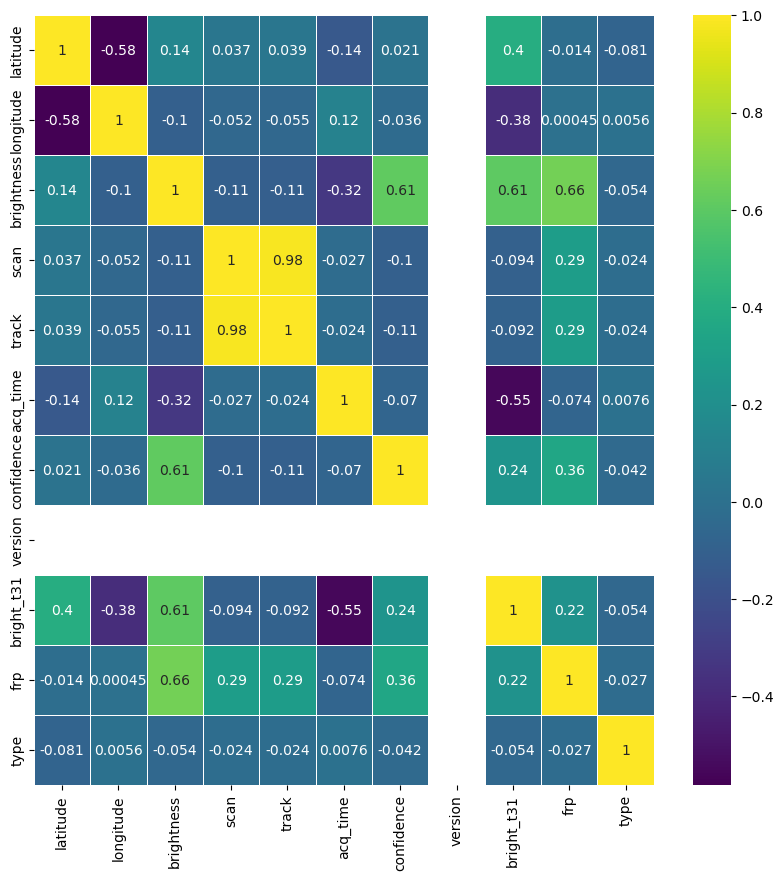

In [15]:
# EDA: describe + correlations heatmap
forest.describe()

plt.figure(figsize=(10, 10))
numeric_forest = forest.select_dtypes(include=[np.number])
corr = numeric_forest.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=.5)

In [16]:
# Categorical summaries
print("The scan column")
print(forest['scan'].value_counts())
print()
print("The aqc_time column")
print(forest['acq_time'].value_counts())
print()
print("The satellite column")
print(forest['satellite'].value_counts())
print()
print("The instrument column")
print(forest['instrument'].value_counts())
print()
print("The version column")
print(forest['version'].value_counts())
print()
print("The daynight column")
print(forest['daynight'].value_counts())

The scan column
scan
1.0    8284
1.1    6000
1.2    3021
1.3    2412
1.4    1848
1.5    1610
1.6    1451
1.7    1281
1.8    1041
1.9     847
2.0     707
2.2     691
2.1     649
2.3     608
2.5     468
2.4     433
2.8     422
3.0     402
2.7     366
2.9     361
2.6     347
3.1     259
3.2     244
3.6     219
3.4     203
3.3     203
3.8     189
3.9     156
4.7     149
4.3     137
3.7     134
3.5     134
4.1     120
4.6     118
4.5     116
4.2     108
4.0     103
4.4     100
4.8      70
Name: count, dtype: int64

The aqc_time column
acq_time
506     851
454     631
122     612
423     574
448     563
       ... 
246       1
1549      1
1724      1
1629      1
302       1
Name: count, Length: 662, dtype: int64

The satellite column
satellite
Aqua     20541
Terra    15470
Name: count, dtype: int64

The instrument column
instrument
MODIS    36011
Name: count, dtype: int64

The version column
version
6.3    36011
Name: count, dtype: int64

The daynight column
daynight
D    28203
N     7808
Na

In [17]:
# Preprocessing: drops, maps, dummies, bins, dates
forest = forest.drop(['track'], axis = 1)

forest = forest.drop(['instrument', 'version'], axis = 1)

daynight_map = {"D": 1, "N": 0}
satellite_map = {"Terra": 1, "Aqua": 0}
forest['daynight'] = forest['daynight'].map(daynight_map)
forest['satellite'] = forest['satellite'].map(satellite_map)

types = pd.get_dummies(forest['type'])
forest = pd.concat([forest, types], axis=1)
forest = forest.drop(['type'], axis = 1)
forest = forest.rename(columns={0: 'type_0', 2: 'type_2', 3: 'type_3'})

bins = [0, 1, 2, 3, 4, 5]
labels = [1,2,3,4,5]
forest['scan_binned'] = pd.cut(forest['scan'], bins=bins, labels=labels)

forest['acq_date'] = pd.to_datetime(forest['acq_date'])
forest = forest.drop(['scan'], axis = 1)
forest['year'] = forest['acq_date'].dt.year
forest['month'] = forest['acq_date'].dt.month
forest['day'] = forest['acq_date'].dt.day

forest.shape

(36011, 17)

In [18]:
# Train/test split
y = forest['confidence']
fin = forest.drop(['confidence', 'acq_date', 'acq_time', 'bright_t31', 'type_0'], axis = 1)
Xtrain, Xtest, ytrain, ytest = train_test_split(fin, y, test_size=0.2, random_state=42)

In [19]:
# Baseline RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(Xtrain, ytrain)
print('RF R^2 train:', rf.score(Xtrain, ytrain))
print('RF R^2 test :', rf.score(Xtest, ytest))

RF R^2 train: 0.9527527333268175
RF R^2 test : 0.6684744706258241
RF R^2 test : 0.6684744706258241


In [20]:

# RandomForestRegressor hyperparameter tuning with RandomizedSearchCV (faster)
rf_param_dist = {
    'n_estimators': [50, 100, 150],  # fewer trees during search
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Avoid double parallelism: RF single-threaded during search, CV uses n_jobs=-1
rf_base = RandomForestRegressor(random_state=42, n_jobs=1)
rf_rs = RandomizedSearchCV(rf_base, rf_param_dist, n_iter=20, cv=2, random_state=42, n_jobs=-1, verbose=2)
rf_rs.fit(Xtrain, ytrain)
print('Best RF params (RandomizedSearchCV):', rf_rs.best_params_)

# Refit best model with more trees and full parallelism
best_params = rf_rs.best_params_.copy()
best_params['n_estimators'] = 300
rf_final = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_final.fit(Xtrain, ytrain)
print('Tuned RF R^2 test (RandomizedSearchCV + refit 300):', rf_final.score(Xtest, ytest))


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best RF params (RandomizedSearchCV): {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Best RF params (RandomizedSearchCV): {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Tuned RF R^2 test (RandomizedSearchCV + refit 300): 0.688025477169255
Tuned RF R^2 test (RandomizedSearchCV + refit 300): 0.688025477169255


In [21]:
# ExtraTreesRegressor baseline and metrics
extra = ExtraTreesRegressor(n_estimators=400, max_features='sqrt', random_state=42, n_jobs=-1)
extra.fit(Xtrain, ytrain)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_train_pred = extra.predict(Xtrain)
y_test_pred = extra.predict(Xtest)
print('ExtraTrees R^2 train:', r2_score(ytrain, y_train_pred))
print('ExtraTrees R^2 test :', r2_score(ytest, y_test_pred))
print('ExtraTrees MAE      :', mean_absolute_error(ytest, y_test_pred))


ExtraTrees R^2 train: 0.9999997997743186
ExtraTrees R^2 test : 0.6854698557234598
ExtraTrees MAE      : 8.931672201946522


In [22]:
# Quick hyperparameter search for ExtraTrees (small for speed)
param_dist = {
    'n_estimators': [200, 300, 400, 600],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 20, 28, 32],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4],
}

et_base = ExtraTreesRegressor(random_state=42, n_jobs=-1)
et_search = RandomizedSearchCV(et_base, param_dist, n_iter=15, cv=2, random_state=42, n_jobs=-1, verbose=1)
et_search.fit(Xtrain, ytrain)
print('Best ExtraTrees params:', et_search.best_params_)

extra_tuned = ExtraTreesRegressor(**et_search.best_params_, random_state=42, n_jobs=-1)
extra_tuned.fit(Xtrain, ytrain)
print('Tuned ExtraTrees R^2 test:', extra_tuned.score(Xtest, ytest))

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best ExtraTrees params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 32}
Best ExtraTrees params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 32}
Tuned ExtraTrees R^2 test: 0.6838398523132152
Tuned ExtraTrees R^2 test: 0.6838398523132152
